In [2]:
# make a fake sequence with ctcf and mystery motif, then slide them around / dream to get a good prediciton
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Must be before importing keras!
import sys
sys.path.insert(0,"/home/kal/CTCF/modules/")
sys.path.insert(0,"/home/kal/CTCF/mass_CTCF/modules/")
import tf_memory_limit
#import matplotlib; matplotlib.use('Agg')  # Must be before importing matplotlib.pyplot or before importing pylab!
from keras import backend as K
import tensorflow as tf
import numpy as np
import ctcfgen
import eval_convnet_ctcf
import ucscgenome
from convnet import Bias
from keras.models import load_model, Model
from keras.layers import Input, Activation
import viz_sequence
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.signal import correlate2d
from sklearn.metrics import precision_recall_curve, roc_curve
from scipy.special import logit

Using TensorFlow backend.


In [31]:
# load the sigmoid model
#model_path = '/home/kal/CTCF/mass_CTCF/output/sigmoid/20170919_150754/20170919_150754_weights_3_248_0.91.hdf5'
# or load the strength model
model_path = '/home/kal/CTCF/mass_CTCF/output/strength/20171128_132105/20171128_132105_weights_3_247_45227.62.hdf5'
model = load_model(model_path, custom_objects={'Bias':Bias})
layer_dict = dict([(layer.name, layer) for layer in model.layers])

get_act = K.function([model.input, K.learning_phase()], [layer_dict['bias'].output])

# get the motifs as sequences
def get_sequence(meme):
    bases = np.argmax(meme, axis=1)
    pwm = np.zeros((bases.shape[0], 4))
    for base, i in zip(pwm, bases):
        base[i] = 1 
    return pwm

ctcf_seqs = [get_sequence(meme) for meme in ctcfgen.CTCF_memes]
broken = np.copy(ctcf_seqs[0])
broken[5] = [0,0,1,0]
broken[5] = [1,0,0,0]
ctcf_seqs.append(broken)
mystery_seqs = [get_sequence(meme) for meme in ctcfgen.mystery_memes]

In [4]:
def rand_seq_gen(size):
    while True:
        random = np.random.choice(np.fromstring('acgt', np.uint8), size=size)
        yield ctcfgen.encode(random).astype(np.float)
r = rand_seq_gen(256)

In [5]:
def scram_seq_gen(motif):
    while True:
        out = np.copy(motif)
        np.random.shuffle(out)
        yield out

In [6]:
# add a ctcf seq -- see how this does in different positions:
def motif_insert_gen(seq, motif):
    #have i track the middle of the insertion
    for i in range(seq.shape[0]):
        new_seq = seq.copy()
        if i-motif.shape[0]//2 < 0: # too early
            new_seq[0:i-motif.shape[0]//2 + motif.shape[0]] = motif[motif.shape[0]//2 - i:]
        elif i-motif.shape[0]//2 + motif.shape[0] > seq.shape[0]: # too late
            new_seq[i-motif.shape[0]//2:seq.shape[0]] = motif[:seq.shape[0]-i+motif.shape[0]//2]
        else: # just right
            new_seq[i-motif.shape[0]//2:i-motif.shape[0]//2 + motif.shape[0]] = motif
        yield new_seq

In [7]:
def get_diffs(random_seq, motif):
    orig_pred = get_act([[random_seq]*32, 0])[0][0][0]
    m = motif_insert_gen(random_seq, motif)
    batches = ctcfgen.filled_batch(batch_size=32, iterable=m)
    preds = np.asarray([get_act([batch, 0]) for batch in batches]).flatten()
    return preds - orig_pred

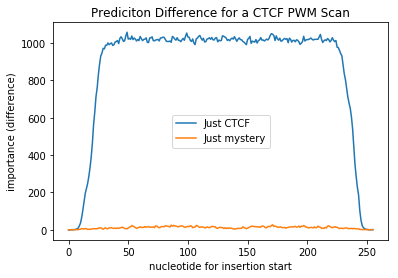

In [8]:
# make 1 pwm plots by inserting a pwm interatvily into a bunch of random sequences
num_sequences = 100 # number of sequences to sample

#for ctcf
all_diffs = list()
for i in range(num_sequences):
    random_seq = next(r)
    all_diffs.append(get_diffs(random_seq, ctcf_seqs[0]))
    
all_diffs = np.asarray(all_diffs)    
cdiffs = all_diffs.mean(axis=0)

#for mystery
all_diffs = list()
for i in range(num_sequences):
    random_seq = next(r)
    all_diffs.append(get_diffs(random_seq, mystery_seqs[0]))
    
all_diffs = np.asarray(all_diffs)    
mdiffs = all_diffs.mean(axis=0)

plt.plot(cdiffs, label = 'Just CTCF')
plt.plot(mdiffs, label = 'Just mystery')
plt.title('Prediciton Difference for a CTCF PWM Scan')
plt.ylabel('importance (difference)')
plt.xlabel('nucleotide for insertion start')
plt.legend()
plt.show()

In [9]:
def corrected_diff(base_seq, motif, num_inserts, plot=False):
    fake_scans = list()
    real_scan = get_diffs(base_seq, motif)
    random_motif = rand_seq_gen(motif.shape[0])
    if num_inserts < 1:
        return real_scan, real_scan
    for i in range(num_inserts):
        fake_scans.append(get_diffs(base_seq, next(random_motif)))
    
    fake_scans = np.asarray(fake_scans) 
    if plot:
        for seq in fake_scans:
            plt.plot(seq)
        plt.title('Prediciton Difference for Random Motif Scans')
        plt.ylabel('importance (difference)')
        plt.xlabel('nucleotide for insertion start')
        plt.show()
    diffs = real_scan - fake_scans.mean(axis=0)
    return diffs, real_scan

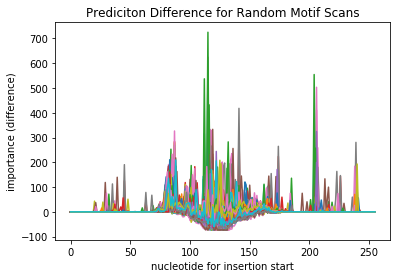

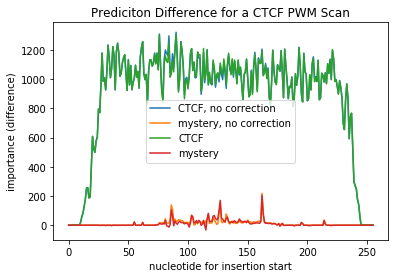

In [10]:
# make 1 pwm plots by inserting a a bunch of pwms into a sample sequence 
num_inserts = 100 # number randomized motifs to do

base_seq = next(r)

#for ctcf
cdiffs, real_cscan = corrected_diff(base_seq, ctcf_seqs[0], num_inserts, plot=True)
#for mystery
mdiffs, real_mscan = corrected_diff(base_seq, mystery_seqs[0], num_inserts)
fake_scans = list()

plt.plot(real_cscan, label = 'CTCF, no correction')
plt.plot(real_mscan, label = 'mystery, no correction')
plt.plot(cdiffs, label = 'CTCF')
plt.plot(mdiffs, label = 'mystery')

plt.title('Prediciton Difference for a CTCF PWM Scan')
plt.ylabel('importance (difference)')
plt.xlabel('nucleotide for insertion start')
plt.legend()
plt.show()

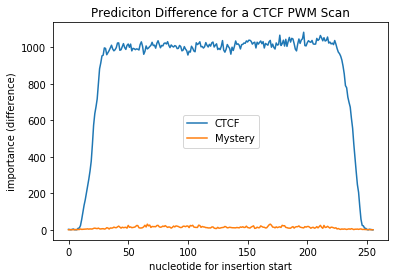

In [34]:
# combine these two types of correction:
# make 1 pwm plots by inserting a pwm interatvily into a bunch of random sequences
num_sequences = 50 # number of sequences to sample
num_inserts = 10 # number randomized motifs to do

#for ctcf
all_diffs = list()
for i in range(num_sequences):
    random_seq = next(r)
    diffs, real_scan = corrected_diff(random_seq, ctcf_seqs[0], num_inserts)
    all_diffs.append(diffs)
    
all_diffs = np.asarray(all_diffs)    
cdiffs = all_diffs.mean(axis=0)

#for mystery
all_diffs = list()
for i in range(num_sequences):
    random_seq = next(r)
    diffs, real_scan = corrected_diff(random_seq, mystery_seqs[0], num_inserts)
    all_diffs.append(diffs)
    
all_diffs = np.asarray(all_diffs)    
mdiffs = all_diffs.mean(axis=0)

plt.plot(cdiffs, label = 'CTCF')
plt.plot(mdiffs, label = 'Mystery')
plt.title('Prediciton Difference for a CTCF PWM Scan')
plt.ylabel('importance (difference)')
plt.xlabel('nucleotide for insertion start')
plt.legend()
plt.show()

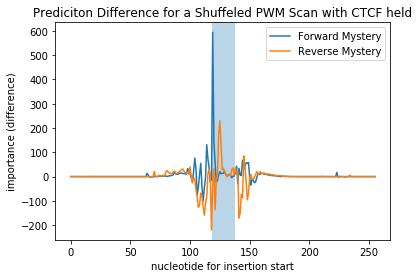

595.815


In [37]:
#now do that with a ctcf motif in the middle - facing forward
ctcf_start = (256 - ctcf_seqs[0].shape[0])//2
num_sequences = 10 # number of sequences to sample
num_inserts = 10 # number randomized motifs to do
r = rand_seq_gen(256)

all_fdiffs = list()
all_rdiffs = list()
all_bad = list()
for i in range(num_sequences):
    random_seq = next(r)
    random_seq[ctcf_start:ctcf_start+ctcf_seqs[0].shape[0]] = ctcf_seqs[4]  #insert ctcf
    fdiffs, real_scan = corrected_diff(random_seq, mystery_seqs[0], num_inserts)
    all_fdiffs.append(fdiffs)
    baddiffs, real_scan = corrected_diff(random_seq, next(rand_seq_gen(mystery_seqs[0].shape[0])), num_inserts)
    all_bad.append(baddiffs)
    rdiffs, real_scan = corrected_diff(random_seq, mystery_seqs[1], num_inserts)
    all_rdiffs.append(rdiffs)
    
all_fdiffs = np.asarray(all_fdiffs) 
all_rdiffs = np.asarray(all_rdiffs) 
all_bad = np.asarray(all_bad) 
final_fdiffs = all_fdiffs.mean(axis=0)
final_rdiffs = all_rdiffs.mean(axis=0)
final_bad = all_bad.mean(axis=0)

plt.plot(final_fdiffs, label = 'Forward Mystery')
plt.plot(final_rdiffs, label = 'Reverse Mystery')
#plt.plot(final_bad, label = 'Noise Motif')

plt.axvspan(ctcf_start, ctcf_start+ctcf_seqs[0].shape[0], alpha=0.3)
plt.title('Prediciton Difference for a Shuffeled PWM Scan with CTCF held')
plt.ylabel('importance (difference)')
plt.xlabel('nucleotide for insertion start')
plt.legend()
plt.show()

print(get_act([ctcfgen.blank_batch(random_seq, 32), 0])[0][0][0])

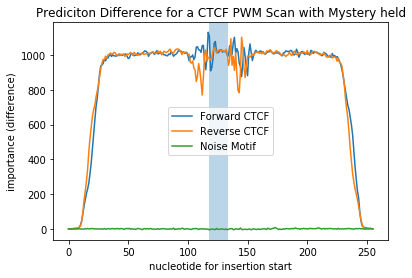

In [13]:
#now do that with a mytery motif in the middle - facing forward
mystery_start = (256 - mystery_seqs[0].shape[0])//2
num_sequences = 200 # number of sequences to sample
num_inserts = 5 # number randomized motifs to do
r = rand_seq_gen(256)

all_fdiffs = list()
all_rdiffs = list()
all_bad = list()
for i in range(num_sequences):
    random_seq = next(r)
    random_seq[mystery_start:mystery_start+mystery_seqs[0].shape[0]] = mystery_seqs[0]  #insert ctcf
    fdiffs, real_scan = corrected_diff(random_seq, ctcf_seqs[0], num_inserts)
    all_fdiffs.append(fdiffs)
    baddiffs, real_scan = corrected_diff(random_seq, next(rand_seq_gen(ctcf_seqs[0].shape[0])), num_inserts)
    all_bad.append(baddiffs)
    rdiffs, real_scan = corrected_diff(random_seq, ctcf_seqs[2], num_inserts)
    all_rdiffs.append(rdiffs)
    
all_fdiffs = np.asarray(all_fdiffs) 
all_rdiffs = np.asarray(all_rdiffs) 
all_bad = np.asarray(all_bad) 
final_fdiffs = all_fdiffs.mean(axis=0)
final_rdiffs = all_rdiffs.mean(axis=0)
final_bad = all_bad.mean(axis=0)

plt.plot(final_fdiffs, label = 'Forward CTCF')
plt.plot(final_rdiffs, label = 'Reverse CTCF')
plt.plot(final_bad, label = 'Noise Motif')

plt.axvspan(ctcf_start, mystery_start+mystery_seqs[0].shape[0], alpha=0.3)
plt.title('Prediciton Difference for a CTCF PWM Scan with Mystery held')
plt.ylabel('importance (difference)')
plt.xlabel('nucleotide for insertion start')
plt.legend()
plt.show()

In [14]:
def scrambeled_diff(base_seq, motif, num_inserts, plot=False):
    fake_scans = list()
    real_scan = get_diffs(base_seq, motif)
    random_motif = scram_seq_gen(motif)
    if num_inserts < 1:
        return real_scan, real_scan
    for i in range(num_inserts):
        fake_scans.append(get_diffs(base_seq, next(random_motif)))
    
    fake_scans = np.asarray(fake_scans) 
    if plot:
        for seq in fake_scans:
            plt.plot(seq)
        plt.title('Prediciton Difference for Scrambeled Motif Scans')
        plt.ylabel('importance (difference)')
        plt.xlabel('nucleotide for insertion start')
        plt.show()
    diffs = real_scan - fake_scans.mean(axis=0)
    return diffs, real_scan

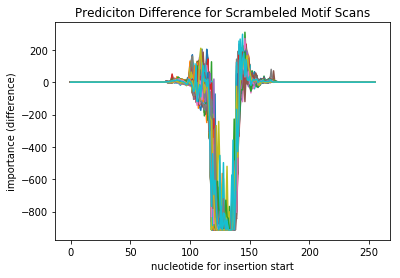

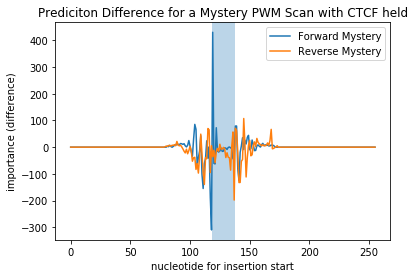

In [15]:
#now do that with a ctcf motif in the middle - facing forward and with scrambled motifs, not random
ctcf_start = (256 - ctcf_seqs[0].shape[0])//2
num_sequences = 1 # number of sequences to sample
num_inserts = 100 # number randomized motifs to do
r = rand_seq_gen(256)

all_fdiffs = list()
all_rdiffs = list()
all_bad = list()
for i in range(num_sequences):
    random_seq = next(r)
    random_seq[ctcf_start:ctcf_start+ctcf_seqs[0].shape[0]] = ctcf_seqs[0]  #insert ctcf
    fdiffs, real_scan = scrambeled_diff(random_seq, mystery_seqs[0], num_inserts, plot=True)
    all_fdiffs.append(fdiffs)
    baddiffs, real_scan = scrambeled_diff(random_seq, next(rand_seq_gen(mystery_seqs[0].shape[0])), num_inserts)
    all_bad.append(baddiffs)
    rdiffs, real_scan = scrambeled_diff(random_seq, mystery_seqs[1], num_inserts)
    all_rdiffs.append(rdiffs)
    
all_fdiffs = np.asarray(all_fdiffs) 
all_rdiffs = np.asarray(all_rdiffs) 
all_bad = np.asarray(all_bad) 
final_fdiffs = all_fdiffs.mean(axis=0)
final_rdiffs = all_rdiffs.mean(axis=0)
final_bad = all_bad.mean(axis=0)

plt.plot(final_fdiffs, label = 'Forward Mystery')
plt.plot(final_rdiffs, label = 'Reverse Mystery')
#plt.plot(final_bad, label = 'Noise Motif')

plt.axvspan(ctcf_start, ctcf_start+ctcf_seqs[0].shape[0], alpha=0.3)
plt.title('Prediciton Difference for a Mystery PWM Scan with CTCF held')
plt.ylabel('importance (difference)')
plt.xlabel('nucleotide for insertion start')
plt.legend()
plt.show()

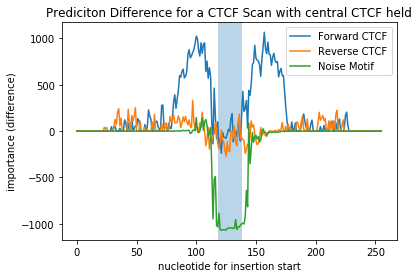

1067.22


In [27]:
# now did the model learn the convergent motif rule?
#now do that with a ctcf motif in the middle - facing forward
ctcf_start = (256 - ctcf_seqs[3].shape[0])//2
num_sequences = 1 # number of sequences to sample
num_inserts = 0 # number randomized motifs to do
r = rand_seq_gen(256)

all_fdiffs = list()
all_rdiffs = list()
all_bad = list()
for i in range(num_sequences):
    random_seq = next(r)
    random_seq[ctcf_start:ctcf_start+ctcf_seqs[0].shape[0]] = ctcf_seqs[0]  #insert ctcf
    fdiffs, real_scan = corrected_diff(random_seq, ctcf_seqs[0], num_inserts)
    all_fdiffs.append(fdiffs)
    baddiffs, real_scan = corrected_diff(random_seq, next(rand_seq_gen(ctcf_seqs[0].shape[0])), num_inserts)
    all_bad.append(baddiffs)
    rdiffs, real_scan = corrected_diff(random_seq, ctcf_seqs[2], num_inserts)
    all_rdiffs.append(rdiffs)
    
all_fdiffs = np.asarray(all_fdiffs) 
all_rdiffs = np.asarray(all_rdiffs) 
all_bad = np.asarray(all_bad) 
final_fdiffs = all_fdiffs.mean(axis=0)
final_rdiffs = all_rdiffs.mean(axis=0)
final_bad = all_bad.mean(axis=0)

plt.plot(final_fdiffs, label = 'Forward CTCF')
plt.plot(final_rdiffs, label = 'Reverse CTCF')
plt.plot(final_bad, label = 'Noise Motif')

plt.axvspan(ctcf_start, ctcf_start+ctcf_seqs[3].shape[0], alpha=0.3)
plt.title('Prediciton Difference for a CTCF Scan with central CTCF held')
plt.ylabel('importance (difference)')
plt.xlabel('nucleotide for insertion start')
plt.legend()
plt.show()

print(get_act([ctcfgen.blank_batch(random_seq, 32), 0])[0][0][0])

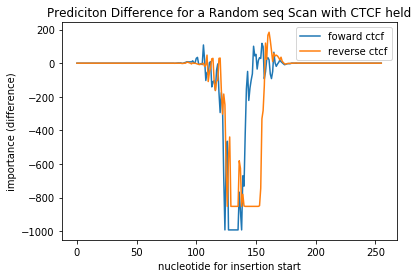

In [17]:
#mystery with ctcf@ 128
random_motif = ctcfgen.encode(np.random.choice(np.fromstring('acgt', np.uint8), size=len(ctcf_seqs[0]))).astype(np.float)
new_seq  = random_seq.copy()
new_seq[128:128+ctcf_seqs[0].shape[0]] = ctcf_seqs[0]
new_pred = get_act([[new_seq]*32, 0])[0][0][0]
m = motif_insert_gen(new_seq, random_motif)
batches = ctcfgen.filled_batch(batch_size=32, iterable=m)
orig_pred = get_act([[random_seq]*32, 0])[0][0][0]
preds = np.asarray([get_act([batch, 0]) for batch in batches]).flatten()
both_diffs = preds - new_pred

##mystery with reverse ctcf@ 128
new_seq  = random_seq.copy()
new_seq[128:128+ctcf_seqs[1].shape[0]] = ctcf_seqs[1]
new_pred = get_act([[new_seq]*32, 0])[0][0][0]
m = motif_insert_gen(new_seq, random_motif)
batches = ctcfgen.filled_batch(batch_size=32, iterable=m)
orig_pred = get_act([[random_seq]*32, 0])[0][0][0]
preds = np.asarray([get_act([batch, 0]) for batch in batches]).flatten()
rboth_diffs = preds - new_pred

plt.plot(both_diffs, label = 'foward ctcf')
plt.plot(rboth_diffs, label = 'reverse ctcf')
plt.title('Prediciton Difference for a Random seq Scan with CTCF held')
plt.ylabel('importance (difference)')
plt.xlabel('nucleotide for insertion start')
plt.legend()
plt.show()

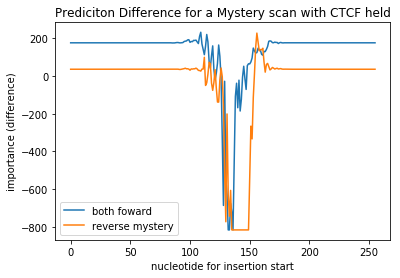

In [18]:
#mystery with ctcf@ 128
new_seq  = random_seq.copy()
new_seq[128:128+ctcf_seqs[0].shape[0]] = ctcf_seqs[0]
m = motif_insert_gen(new_seq, mystery_seqs[0])
batches = ctcfgen.filled_batch(batch_size=32, iterable=m)
orig_pred = get_act([[random_seq]*32, 0])[0][0][0]
preds = np.asarray([get_act([batch, 0]) for batch in batches]).flatten()
both_diffs = preds - orig_pred

##mystery with reverse ctcf@ 128
new_seq  = random_seq.copy()
new_seq[128:128+ctcf_seqs[1].shape[0]] = ctcf_seqs[1]
m = motif_insert_gen(new_seq, mystery_seqs[0])
batches = ctcfgen.filled_batch(batch_size=32, iterable=m)
orig_pred = get_act([[random_seq]*32, 0])[0][0][0]
preds = np.asarray([get_act([batch, 0]) for batch in batches]).flatten()
rboth_diffs = preds - orig_pred

plt.plot(both_diffs, label = 'both foward')
plt.plot(rboth_diffs, label = 'reverse mystery')
plt.title('Prediciton Difference for a Mystery scan with CTCF held')
plt.ylabel('importance (difference)')
plt.xlabel('nucleotide for insertion start')
plt.legend()
plt.show()

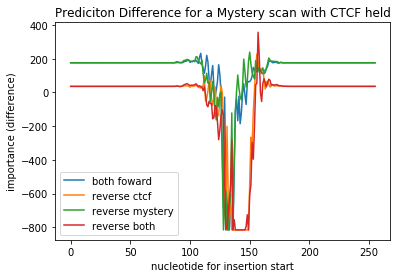

In [19]:
#mystery with ctcf@ 128
new_seq  = random_seq.copy()
new_seq[128:128+ctcf_seqs[0].shape[0]] = ctcf_seqs[0]
m = motif_insert_gen(new_seq, mystery_seqs[0])
batches = ctcfgen.filled_batch(batch_size=32, iterable=m)
orig_pred = get_act([[random_seq]*32, 0])[0][0][0]
preds = np.asarray([get_act([batch, 0]) for batch in batches]).flatten()
both_diffs = preds - orig_pred

##mystery with reverse ctcf@ 128
new_seq  = random_seq.copy()
new_seq[128:128+ctcf_seqs[1].shape[0]] = ctcf_seqs[1]
m = motif_insert_gen(new_seq, mystery_seqs[0])
batches = ctcfgen.filled_batch(batch_size=32, iterable=m)
orig_pred = get_act([[random_seq]*32, 0])[0][0][0]
preds = np.asarray([get_act([batch, 0]) for batch in batches]).flatten()
rboth_diffs = preds - orig_pred

# and with reverse mystery
#mystery with ctcf@ 128
new_seq  = random_seq.copy()
new_seq[128:128+ctcf_seqs[0].shape[0]] = ctcf_seqs[0]
m = motif_insert_gen(new_seq, mystery_seqs[1])
batches = ctcfgen.filled_batch(batch_size=32, iterable=m)
orig_pred = get_act([[random_seq]*32, 0])[0][0][0]
preds = np.asarray([get_act([batch, 0]) for batch in batches]).flatten()
mrboth_diffs = preds - orig_pred

#mystery with reverse ctcf@ 128
new_seq  = random_seq.copy()
new_seq[128:128+ctcf_seqs[1].shape[0]] = ctcf_seqs[1]
m = motif_insert_gen(new_seq, mystery_seqs[1])
batches = ctcfgen.filled_batch(batch_size=32, iterable=m)
orig_pred = get_act([[random_seq]*32, 0])[0][0][0]
preds = np.asarray([get_act([batch, 0]) for batch in batches]).flatten()
rrboth_diffs = preds - orig_pred

plt.plot(both_diffs, label = 'both foward')
plt.plot(rboth_diffs, label = 'reverse ctcf')
plt.plot(mrboth_diffs, label = 'reverse mystery')
plt.plot(rrboth_diffs, label = 'reverse both')
plt.title('Prediciton Difference for a Mystery scan with CTCF held')
plt.ylabel('importance (difference)')
plt.xlabel('nucleotide for insertion start')
plt.legend()
plt.show()

In [20]:
predictionbatch = next(batches)
out=get_act([batch, 0])

StopIteration: 